In [41]:
import numpy as np
import matplotlib.pyplot as plt

In [42]:
import h5py
from netCDF4 import Dataset
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
import matplotlib as mpl
# ESM_2025/f09.F2000.ESMclass_0303class_ex3.t01.cam.h0.2017-09-07-00000.nc

In [178]:
class NthTimesAnomaly:
    def __init__(self, n):
        """
        Initialize the NthTimesAnomaly object with a scaling factor.

        Parameters:
        - n: scaling factor for the anomaly
        """
        self.n = n  # Scaling factor
        self.mean = None
        self.anomaly = None

    def update_data(self, input):
        """
        Update the data and calculate the anomaly.

        Parameters:
        - input: numpy array of shape (time, lat, lon)
        """
        self.mean = input.mean(axis=-1)[:,:,None]  # Calculate the mean along the last axis
        self.anomaly = input - self.mean  # Calculate the anomaly

    def get_anomaly(self):
        """
        Return the calculated anomaly and mean.
        """
        return self.anomaly, self.mean

    def nth_times_anomaly(self):
        """
        Scale the anomaly by the factor n and add back the mean.
        """
        if self.anomaly is None or self.mean is None:
            raise ValueError("Data not set. Please update the data using the update_data method.")
        new = self.mean + self.anomaly * self.n
        return new

In [201]:
with Dataset("/data92/PeterChang/ESM_2025/sst_HadOIBl_bc_0.9x1.25_clim_c040926.nc", "r") as f:
    print(f.variables.keys())
    date = f['date'][:]
    datesec = f['datesec'][:]
    
    time = f['time'][:]
    lon = f['lon'][:]
    lat = f['lat'][:]
    
    sst_cpl     = f['SST_cpl'][:]
    sst_cpl_pre = f['SST_cpl_prediddle'][:]

    ice_cov = f['ice_cov'][:]
    ice_cov_pre = f['ice_cov_prediddle'][:]    

dict_keys(['date', 'datesec', 'lon', 'lat', 'time', 'ice_cov', 'ice_cov_prediddle', 'SST_cpl', 'SST_cpl_prediddle'])


In [206]:
sst_cpl.shape

(12, 192, 288)

In [211]:
n = 1.01
anomaly_calculator = NthTimesAnomaly(n)

# Update the data and calculate scaled anomalies
anomaly_calculator.update_data(sst_cpl)
sst_cpl_scaled_anomaly = anomaly_calculator.nth_times_anomaly()

anomaly_calculator.update_data(sst_cpl_pre)
sst_cpl_pre_scaled_anomaly = anomaly_calculator.nth_times_anomaly()

anomaly_calculator.update_data(ice_cov)
ice_cov_scaled_anomaly = anomaly_calculator.nth_times_anomaly()

anomaly_calculator.update_data(ice_cov_pre)
ice_cov_pre_scaled_anomaly = anomaly_calculator.nth_times_anomaly()

In [212]:
print("SST CPL scaled anomaly shape:", sst_cpl_scaled_anomaly.shape)
print("SST CPL pre scaled anomaly shape:", sst_cpl_pre_scaled_anomaly.shape)
print("Ice cover scaled anomaly shape:", ice_cov_scaled_anomaly.shape)

SST CPL scaled anomaly shape: (12, 192, 288)
SST CPL pre scaled anomaly shape: (12, 192, 288)
Ice cover scaled anomaly shape: (12, 192, 288)


In [213]:
lon.shape

(288,)

In [214]:
with Dataset("/data92/PeterChang/ESM_2025/sst_HadOIBl_bc_0.9x1.25_clim_c040926_1.01times_anomaly.nc", "w") as f:
    # Create dimensions
    f.createDimension("time", len(time))
    f.createDimension("lat", len(lat))
    f.createDimension("lon", len(lon))

    # Create variables
    times = f.createVariable("time", np.float32, ("time",))
    lats = f.createVariable("lat", np.float32, ("lat",))
    lons = f.createVariable("lon", np.float32, ("lon",))

    dates = f.createVariable("date", np.int32, ("time",))
    datesecs = f.createVariable("datesec", np.int32, ("time",))

    sst_anom = f.createVariable("SST_cpl", np.float32, ("time", "lat", "lon"))
    sst_pre_anom = f.createVariable("SST_cpl_prediddle", np.float32, ("time", "lat", "lon"))
    ice_anom = f.createVariable("ice_cov", np.float32, ("time", "lat", "lon"))
    ice_pre_anom = f.createVariable("ice_cov_prediddle", np.float32, ("time", "lat", "lon"))

    # Assign data to variables
    times[:] = time
    lats[:] = lat
    lons[:] = lon

    dates[:] = date
    datesecs[:] = datesec

    sst_anom[:, :, :] = sst_cpl_scaled_anomaly
    sst_pre_anom[:, :, :] = sst_cpl_pre # sst_cpl_pre_scaled_anomaly
    ice_anom[:, :, :] = ice_cov # ice_cov_scaled_anomaly
    ice_pre_anom[:, :, :] = ice_cov_pre # ice_cov_pre_scaled_anomaly

    # Add metadata
    f.description = "SST and ice cover scaled anomalies from HadOIBl dataset"
    f.source = "Calculated from SST_cpl and SST_cpl_prediddle, ice_cov and ice_cov_prediddle with scaling factor 1.1"
    times.units = "days since 1850-01-01"
    lats.units = "degrees_north"
    lons.units = "degrees_east"
    dates.units = "YYYYMMDD"
    datesecs.units = "seconds since midnight"
    sst_anom.units = "K"
    ice_anom.units = "fraction"

    print("Scaled anomalies saved successfully!")


Scaled anomalies saved successfully!


In [215]:
sst_cpl.shape

(12, 192, 288)

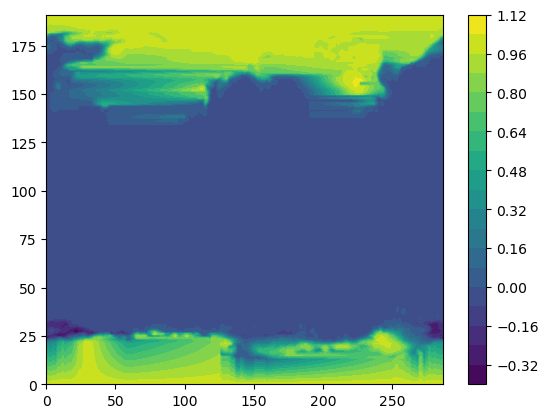

In [216]:
plt.figure()
plt.contourf(ice_cov[0], levels=21)
# plt.contourf(ice_cov_pre[0], levels=21)

plt.colorbar()

In [217]:
sst_cpl.shape

(12, 192, 288)

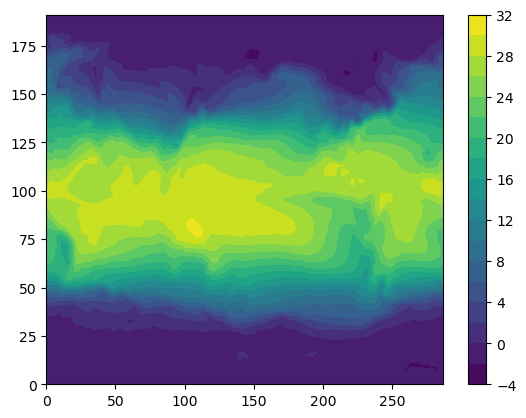

In [223]:
plt.figure()
plt.contourf(sst_cpl[-1], levels=21)
# plt.contourf(sst_cpl_pre[0], levels=21)

plt.colorbar()

In [219]:
with Dataset("/data92/PeterChang/ESM_2025/sst_HadOIBl_bc_0.9x1.25_clim_c040926_1.01times_anomaly.nc", "r") as f:
    print(f.variables.keys())
    time = f['time'][:]
    lon = f['lon'][:]
    lat = f['lat'][:]
    
    sst_cpl_15     = f['SST_cpl'][:]
    sst_cpl_pre_15 = f['SST_cpl_prediddle'][:]

    ice_cov_15 = f['ice_cov'][:]
    ice_cov_pre_15 = f['ice_cov_prediddle'][:]    

dict_keys(['time', 'lat', 'lon', 'date', 'datesec', 'SST_cpl', 'SST_cpl_prediddle', 'ice_cov', 'ice_cov_prediddle'])


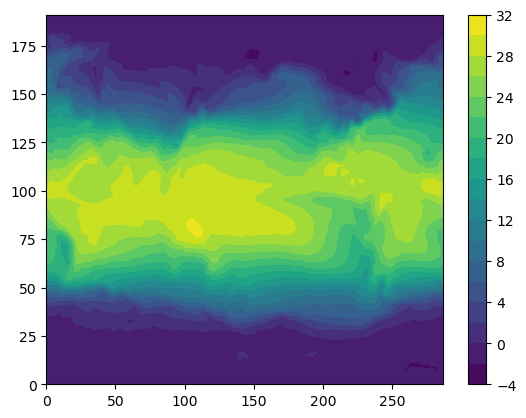

In [224]:
plt.figure()
plt.contourf(sst_cpl[-1], levels=21)
# plt.contourf(sst_cpl_pre[0], levels=21)

plt.colorbar()

In [321]:
with Dataset("f09.F2000_0101_0601_daily.nc", "r") as f:
    print(f.variables.keys())
    u850 = f["U850"][:]
    v850 = f["V850"][:]

    q = f["Q"][:]
    
    PRECL = f["PRECL"][:]
    

dict_keys(['time', 'time_bnds', 'slat', 'lat', 'lon', 'lev', 'lev_bnds', 'ilev', 'ilev_bnds', 'date', 'datesec', 'w_stag', 'nlon', 'wnummax', 'gw', 'ndcur', 'nscur', 'co2vmr', 'ch4vmr', 'n2ovmr', 'f11vmr', 'f12vmr', 'sol_tsi', 'nsteph', 'AEROD_v', 'ANRAIN', 'ANSNOW', 'AODDUST1', 'AODDUST3', 'AODVIS', 'AQRAIN', 'AQSNOW', 'AREI', 'AREL', 'AWNC', 'AWNI', 'BURDEN1', 'BURDEN2', 'BURDEN3', 'BURDENBC', 'BURDENDUST', 'BURDENPOM', 'BURDENSEASALT', 'BURDENSO4', 'BURDENSOA', 'CCN3', 'CDNUMC', 'CGH', 'CGS', 'CLDHGH', 'CLDICE', 'CLDLIQ', 'CLDLOW', 'CLDMED', 'CLDTOT', 'CLOUD', 'DCQ', 'DMS_SRF', 'DTCOND', 'DTV', 'EMISCLD', 'FICE', 'FLDS', 'FLNS', 'FLNSC', 'FLNT', 'FLNTC', 'FLUT', 'FLUTC', 'FREQI', 'FREQL', 'FREQR', 'FREQS', 'FSDS', 'FSDSC', 'FSNS', 'FSNSC', 'FSNT', 'FSNTC', 'FSNTOA', 'FSNTOAC', 'FSUTOA', 'H2O2_SRF', 'H2SO4_SRF', 'ICEFRAC', 'ICIMR', 'ICWMR', 'IWC', 'KBFS', 'KHFS', 'KQFS', 'KSCT', 'KSCU', 'KVF', 'KVH', 'KVM', 'LANDFRAC', 'LHFLX', 'LWCF', 'NUMICE', 'NUMLIQ', 'OCNFRAC', 'OMEGA', 'OMEGAT'

In [411]:
def plot_mjo_phase_space(figsize):
    
    import numpy as np
    from matplotlib import pyplot as plt
    import matplotlib.lines as lines
    
    fig, ax = plt.subplots(1,1,figsize=figsize) 
    
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    ax.set_xticks(range(-4,5))
    ax.set_yticks(range(-4,5))

    # plot mjo phase diagram lines
    line1 = lines.Line2D([np.cos(np.pi/4), 4], [np.sin(np.pi/4), 4], color='black', linestyle='--', lw=1)
    ax.add_line(line1)
        
    line2 = lines.Line2D([np.cos(3*np.pi/4), -4], [np.sin(np.pi/4), 4], color='black', linestyle='--', lw=1)
    ax.add_line(line2)
        
    line3 = lines.Line2D([np.cos(np.pi/4), 4], [np.sin(7*np.pi/4), -4], color='black', linestyle='--', lw=1)
    ax.add_line(line3)
        
    line4 = lines.Line2D([np.cos(3*np.pi/4), -4], [np.sin(7*np.pi/4), -4], color='black', linestyle='--', lw=1)
    ax.add_line(line4)
        
    line5 = lines.Line2D([-4, -1], [0, 0], color='black', linestyle='--', lw=1)
    ax.add_line(line5)
        
    line6 = lines.Line2D([1, 4], [0, 0], color='black', linestyle='--', lw=1)
    ax.add_line(line6)
        
    line7 = lines.Line2D([0, 0], [1, 4], color='black', linestyle='--', lw=1)
    ax.add_line(line7)
        
    line8 = lines.Line2D([0, 0], [-1, -4], color='black', linestyle='--', lw=1)
    ax.add_line(line8)
        
    amp1_circ = plt.Circle((0, 0), 1, color='black', fill=False)
    ax.add_patch(amp1_circ)
        
    # add phase diagram texts
    ax.text( 1,3,'Phase 6', size='x-large', weight='semibold')
    ax.text(-2,3,'Phase 7', size='x-large', weight='semibold')
    ax.text(2.8,1  ,'Phase 5', size='x-large', weight='semibold', ha='center')
    ax.text(-2.8,1  ,'Phase 8', size='x-large', weight='semibold', ha='center')
        
    ax.text( 1,-3,'Phase 3', size='x-large', weight='semibold')
    ax.text(-2,-3,'Phase 2', size='x-large', weight='semibold')
    ax.text(2.8,-1  ,'Phase 4', size='x-large', weight='semibold', ha='center')
    ax.text(-2.8,-1  ,'Phase 1', size='x-large', weight='semibold', ha='center')
        
    ax.text( 0,3.7,'Pacific Ocean', ha='center', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text( 0,-3.8,'Indian Ocean', ha='center', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text(-3.8,0,'West. Hem., Africa', va='center', rotation='vertical', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text(3.7,0,'Maritime Continent', va='center', rotation='vertical', bbox=dict(facecolor='white', edgecolor='white'))
        
    ax.set_xlabel('RMM1')
    ax.set_ylabel('RMM2')

    return fig, ax

In [370]:
u850.shape

(153, 288)

dict_keys(['time', 'time_bnds', 'slat', 'lat', 'lon', 'lev', 'lev_bnds', 'ilev', 'ilev_bnds', 'date', 'datesec', 'w_stag', 'nlon', 'wnummax', 'gw', 'ndcur', 'nscur', 'co2vmr', 'ch4vmr', 'n2ovmr', 'f11vmr', 'f12vmr', 'sol_tsi', 'nsteph', 'AEROD_v', 'ANRAIN', 'ANSNOW', 'AODDUST1', 'AODDUST3', 'AODVIS', 'AQRAIN', 'AQSNOW', 'AREI', 'AREL', 'AWNC', 'AWNI', 'BURDEN1', 'BURDEN2', 'BURDEN3', 'BURDENBC', 'BURDENDUST', 'BURDENPOM', 'BURDENSEASALT', 'BURDENSO4', 'BURDENSOA', 'CCN3', 'CDNUMC', 'CGH', 'CGS', 'CLDHGH', 'CLDICE', 'CLDLIQ', 'CLDLOW', 'CLDMED', 'CLDTOT', 'CLOUD', 'DCQ', 'DMS_SRF', 'DTCOND', 'DTV', 'EMISCLD', 'FICE', 'FLDS', 'FLNS', 'FLNSC', 'FLNT', 'FLNTC', 'FLUT', 'FLUTC', 'FREQI', 'FREQL', 'FREQR', 'FREQS', 'FSDS', 'FSDSC', 'FSNS', 'FSNSC', 'FSNT', 'FSNTC', 'FSNTOA', 'FSNTOAC', 'FSUTOA', 'H2O2_SRF', 'H2SO4_SRF', 'ICEFRAC', 'ICIMR', 'ICWMR', 'IWC', 'KBFS', 'KHFS', 'KQFS', 'KSCT', 'KSCU', 'KVF', 'KVH', 'KVM', 'LANDFRAC', 'LHFLX', 'LWCF', 'NUMICE', 'NUMLIQ', 'OCNFRAC', 'OMEGA', 'OMEGAT'

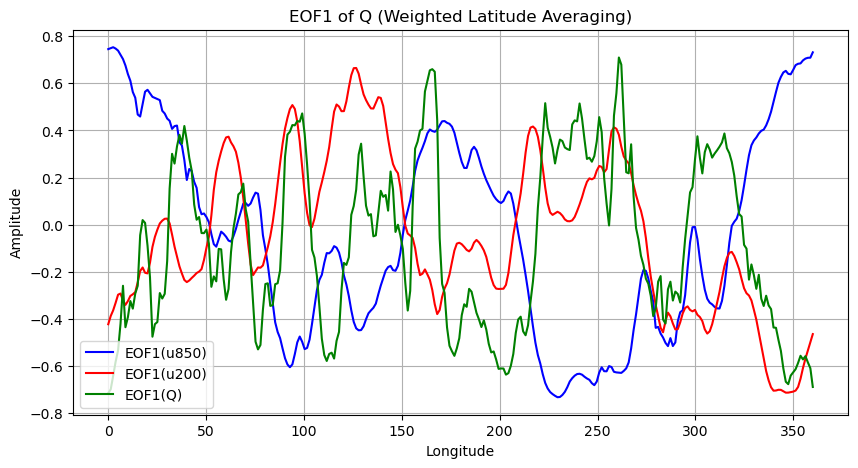

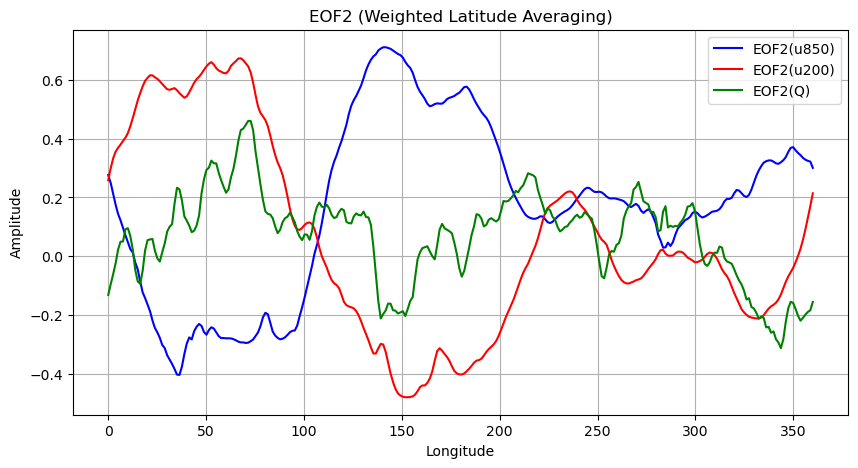

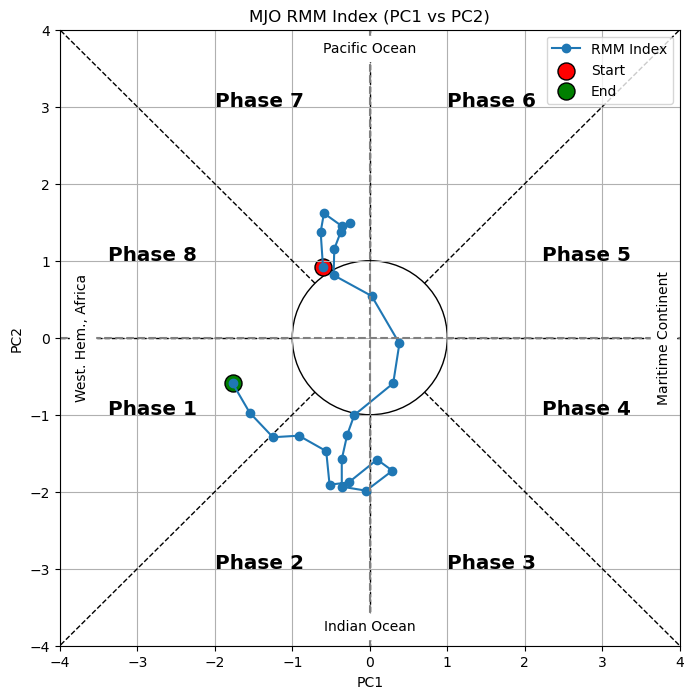

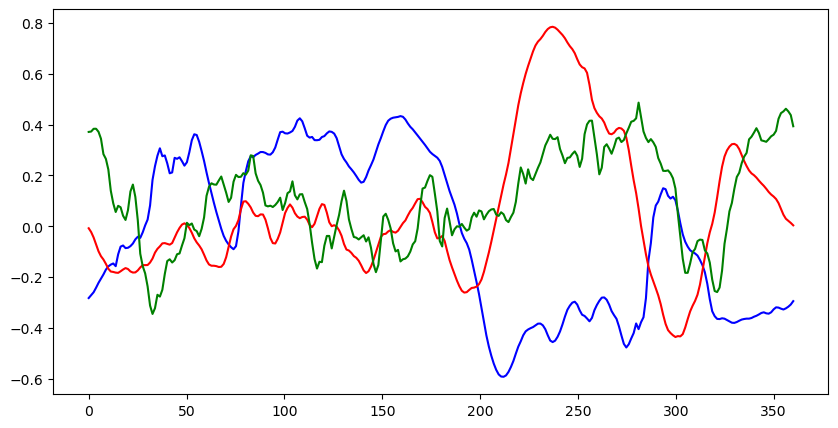

In [594]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from EOF import EOF

# Step 1: Load Data
with Dataset("f09.F2000_0101_0601_daily.nc", "r") as f:
    print(f.variables.keys())
    u850 = f["U850"][:]
    v850 = f["V850"][:]
    precl = f["PRECL"][:]
    u200 = f["U200"][:]
    Q = f["FLNT"][:] 
    lat = f["lat"][:]
    time = f["time"][:]
print(Q.shape)
# Step 2: Select latitude range (-15 to 15)
lat_mask = (lat >= -15) & (lat <= 15)
print("Selected latitude indices:", np.where(lat_mask)[0])

# Subset the data for the selected latitudes
u850 = u850[:, lat_mask, :]
v850 = v850[:, lat_mask, :]
precl = precl[:, lat_mask, :]
u200 = u200[:, lat_mask, :]
Q = Q[:, lat_mask, :]
print("Shape after latitude selection (u850):", u850.shape)



# Step 3: Column integrated Q (mean over levels)
# q_int = np.mean(Q, axis=1)  # Direct mean over vertical levels
q_int = Q
print("Integrated Q shape:", q_int.shape)

# Step 4: Latitude averaging with weighting
def latitude_weighted_average(data, lat):
    """
    Perform latitude-weighted averaging to obtain zonal mean.
    """
    # Calculate the weights
    weights = np.sqrt(np.cos(np.deg2rad(lat)))
    weights /= weights.sum()  # Normalize weights

    # Apply the weights to the data (broadcasting the weights along latitude)
    weighted_data = data * weights[:, np.newaxis]
    # Sum over latitude with weights applied
    return np.sum(weighted_data, axis=1)


# Apply latitude-weighted averaging to each variable
u850 = latitude_weighted_average(u850, lat[lat_mask])
v850 = latitude_weighted_average(v850, lat[lat_mask])
precl = latitude_weighted_average(precl, lat[lat_mask])
u200 = latitude_weighted_average(u200, lat[lat_mask])
q_int = latitude_weighted_average(q_int, lat[lat_mask])
print("Shape after latitude-weighted averaging (u850):", u850.shape)

# Step 5: Remove seasonal cycle
# def remove_seasonal_cycle(data, time):
#     """
#     Remove seasonal cycle by calculating monthly means.
#     """
#     time_len, lon_dim = data.shape
#     data_anom = np.empty_like(data)

#     # Convert time to month (assuming time is in days)
#     months = (time % 365) // 30 + 1

#     for month in range(1, 13):
#         month_indices = np.where(months == month)[0]
#         month_mean = np.mean(data[month_indices], axis=0)
#         data_anom[month_indices] = data[month_indices] - month_mean

#     return data_anom
from scipy.signal import filtfilt, butter

def band_pass_filter(data, lowcut=1/60, highcut=1/14, fs=1):
    """
    Band-pass filter to isolate MJO signals (14~60 days).
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(2, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Apply band-pass filter to isolate MJO signal
u850 = band_pass_filter(u850, lowcut=1/60, highcut=1/14)
u200 = band_pass_filter(u200, lowcut=1/60, highcut=1/14)
q_int = band_pass_filter(q_int, lowcut=1/60, highcut=1/14)
v850 = band_pass_filter(v850, lowcut=1/60, highcut=1/14)
precl = band_pass_filter(precl, lowcut=1/60, highcut=1/14)

print("Filtered shape (u850):", u850.shape)

# Remove seasonal cycle from each variable
# u850 = remove_seasonal_cycle(u850, time)
# v850 = remove_seasonal_cycle(v850, time)
# precl = remove_seasonal_cycle(precl, time)
# u200 = remove_seasonal_cycle(u200, time)
# q_int = remove_seasonal_cycle(q_int, time)

# Step 6: Preprocess Data (remove overall mean and normalize)
def preprocess(data):
    data_anom = data - np.mean(data, axis=0) # anamoly to time
    data_std = np.std(data_anom, axis=0)
    # data_std[data_std == 0] = 1
    data_norm = data_anom / data_std
    return data_norm

# Preprocess each variable
print(u850.shape)
u850_norm = preprocess(u850)
v850_norm = preprocess(v850)
u200_norm = preprocess(u200)
q_int_norm = preprocess(q_int)


# Step 7: Flatten and combine variables
time_dim, lon_dim = u850.shape
u850_flat = u850_norm.reshape(time_dim, lon_dim)
v850_flat = v850_norm.reshape(time_dim, lon_dim)

u200_flat = u200_norm.reshape(time_dim, lon_dim)
q_int_flat = q_int_norm.reshape(time_dim, lon_dim)

# combined = np.hstack((u850_flat, u200_flat, q_int_flat))
### FIXED! should use concatenate not hstack
# Concatenate in the correct order (variables are grouped, not mixed)
combined = np.concatenate((u850_flat, u200_flat, q_int_flat), axis=1) # (time, lon)
print("Combined shape after preprocessing:", combined.shape)

# Step 8: Calculate EOF and PC with latitude weighting
def Cal_EOF_PC(input_data):
    """
    Calculate EOF and PC from input data.
    """
    # Initialize an EOF instance
    n_component = min(input_data.shape[0], input_data.size // input_data.shape[0])
    print("n_component:", n_component)
    eof_instance = EOF((input_data,), n_components=n_component, field="1D")
    eof_instance.get()

    # Extract EOFs and PCs
    EOF1, EOF2, EOF3 = eof_instance.EOF[:3]
    PC1, PC2, PC3 = eof_instance.PC[:3]

    # Normalize PCs
    PC1_norm = (PC1 - PC1.mean()) / PC1.std()
    PC2_norm = (PC2 - PC2.mean()) / PC2.std()
    PC3_norm = (PC3 - PC3.mean()) / PC3.std()
    

    #
    EOF1_norm = EOF1 * PC1.std() # (EOF1 - EOF1.mean()) / EOF1.std()
    EOF2_norm = EOF2 * PC2.std() # (EOF2 - EOF2.mean()) / EOF2.std()
    EOF3_norm = EOF3 * PC3.std() # (EOF2 - EOF2.mean()) / EOF2.std()
    
    return PC1_norm, PC2_norm, PC3_norm, EOF1_norm, EOF2_norm, EOF3_norm



PC1, PC2, PC3, EOF1, EOF2, EOF3 = Cal_EOF_PC(combined)

# Step 9: Plot EOF1 of Q
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0,360,288),EOF1[:288], label='EOF1(u850)', color='blue')
plt.plot(np.linspace(0,360,288),EOF1[288:288*2], label='EOF1(u200)', color='Red')
plt.plot(np.linspace(0,360,288),EOF1[288*2:288*3], label='EOF1(Q)', color='Green')
# plt.plot(np.linspace(0,360,288),EOF1[288*3:288*4], label='EOF2(v850)', color='Orange')



plt.title('EOF1 of Q (Weighted Latitude Averaging)')
plt.xlabel('Longitude')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot EOF1 of Q
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0,360,288),EOF2[:288], label='EOF2(u850)', color='blue')
plt.plot(np.linspace(0,360,288),EOF2[288:288*2], label='EOF2(u200)', color='Red')
plt.plot(np.linspace(0,360,288),EOF2[288*2:288*3], label='EOF2(Q)', color='Green')
# plt.plot(np.linspace(0,360,288),EOF2[288*3:288*4], label='EOF2(v850)', color='Orange')



plt.title('EOF2 (Weighted Latitude Averaging)')
plt.xlabel('Longitude')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()


# Step 10: Plot RMM Index (PC1 vs PC2)
start = 30
end   = 55
fig, ax = plot_mjo_phase_space(figsize=(8,8))
ax.plot(PC1[start:end], PC2[start:end], marker='o', linestyle='-', label='RMM Index')
ax.scatter(PC1[start], PC2[start], color='red', edgecolors='black', s=150, label='Start')
ax.scatter(PC1[int(end-1)], PC2[int(end-1)], color='green', edgecolors='black', s=150, label='End')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('MJO RMM Index (PC1 vs PC2)')
ax.axhline(0, color='gray', linestyle='--')
ax.axvline(0, color='gray', linestyle='--')
ax.grid(True)
ax.legend()
plt.show()
#################################################################################
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0,360,288),EOF3[:288], label='EOF3(u850)', color='blue')
plt.plot(np.linspace(0,360,288),EOF3[288:288*2], label='EOF3(u200)', color='Red')
plt.plot(np.linspace(0,360,288),EOF3[288*2:288*3], label='EOF3(Q)', color='Green')


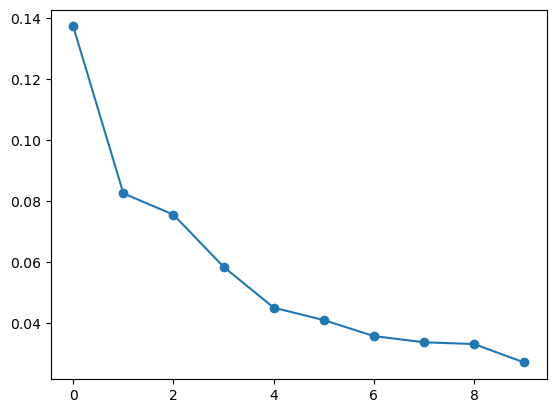

In [574]:
explain[0] + explain[1]

0.2197925767043566

In [587]:
Q.shape

(153, 32, 288)

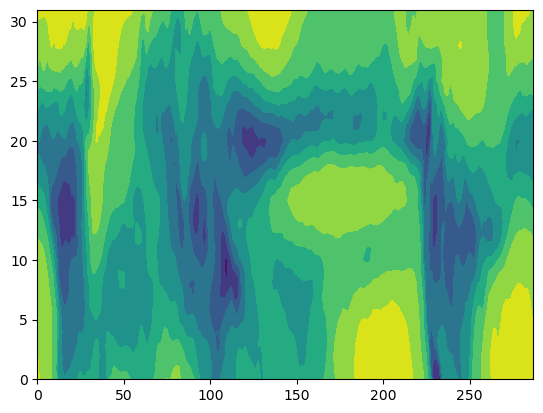

In [588]:
plt.figure()
plt.contourf(Q[:].mean(axis=0), levels=11)

dict_keys(['time', 'time_bnds', 'slat', 'lat', 'lon', 'lev', 'lev_bnds', 'ilev', 'ilev_bnds', 'date', 'datesec', 'w_stag', 'nlon', 'wnummax', 'gw', 'ndcur', 'nscur', 'co2vmr', 'ch4vmr', 'n2ovmr', 'f11vmr', 'f12vmr', 'sol_tsi', 'nsteph', 'AEROD_v', 'ANRAIN', 'ANSNOW', 'AODDUST1', 'AODDUST3', 'AODVIS', 'AQRAIN', 'AQSNOW', 'AREI', 'AREL', 'AWNC', 'AWNI', 'BURDEN1', 'BURDEN2', 'BURDEN3', 'BURDENBC', 'BURDENDUST', 'BURDENPOM', 'BURDENSEASALT', 'BURDENSO4', 'BURDENSOA', 'CCN3', 'CDNUMC', 'CGH', 'CGS', 'CLDHGH', 'CLDICE', 'CLDLIQ', 'CLDLOW', 'CLDMED', 'CLDTOT', 'CLOUD', 'DCQ', 'DMS_SRF', 'DTCOND', 'DTV', 'EMISCLD', 'FICE', 'FLDS', 'FLNS', 'FLNSC', 'FLNT', 'FLNTC', 'FLUT', 'FLUTC', 'FREQI', 'FREQL', 'FREQR', 'FREQS', 'FSDS', 'FSDSC', 'FSNS', 'FSNSC', 'FSNT', 'FSNTC', 'FSNTOA', 'FSNTOAC', 'FSUTOA', 'H2O2_SRF', 'H2SO4_SRF', 'ICEFRAC', 'ICIMR', 'ICWMR', 'IWC', 'KBFS', 'KHFS', 'KQFS', 'KSCT', 'KSCU', 'KVF', 'KVH', 'KVM', 'LANDFRAC', 'LHFLX', 'LWCF', 'NUMICE', 'NUMLIQ', 'OCNFRAC', 'OMEGA', 'OMEGAT'

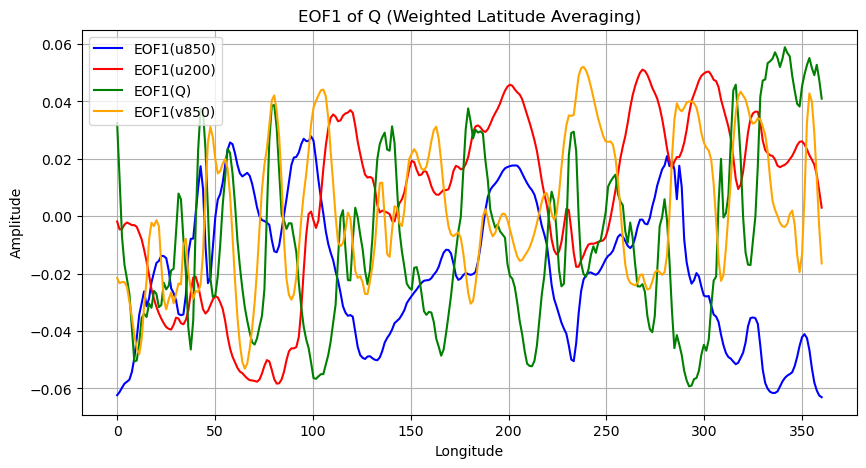

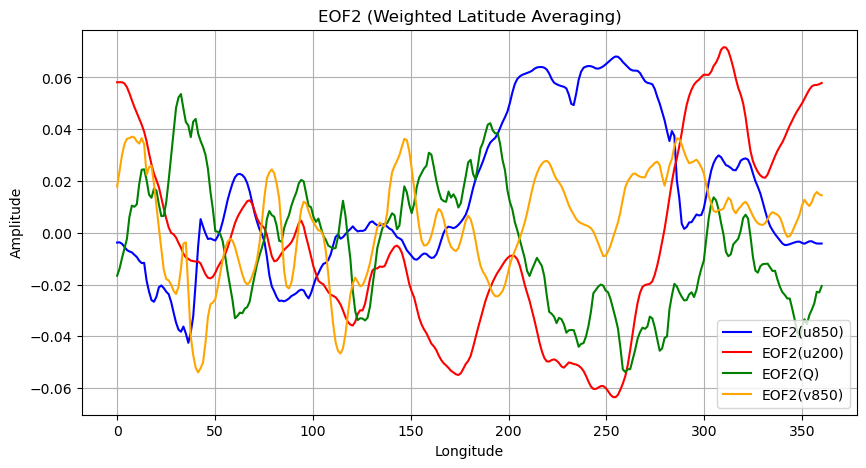

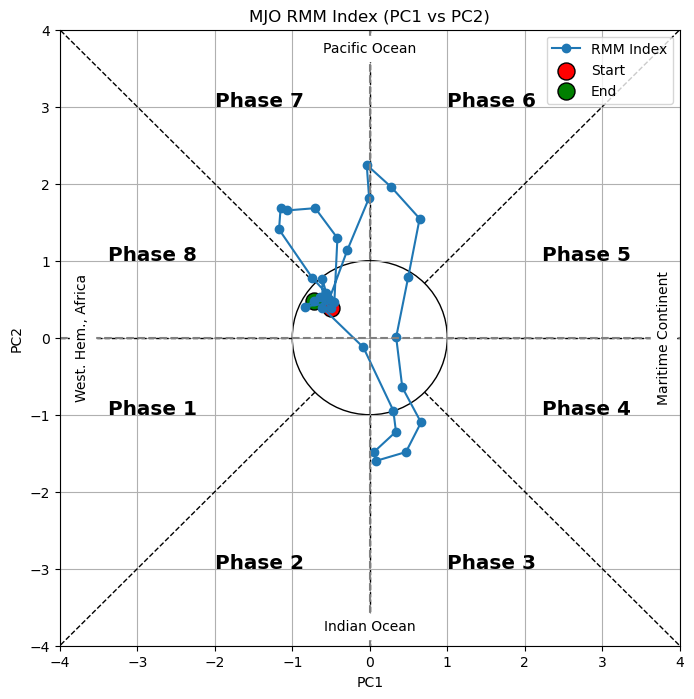

In [559]:
# import numpy as np
# from netCDF4 import Dataset
# import matplotlib.pyplot as plt
# from EOF import EOF

# # Step 1: Load Data
# with Dataset("f09.F2000_0101_0601_daily.nc", "r") as f:
#     print(f.variables.keys())
#     u850 = f["U850"][:]
#     v850 = f["V850"][:]
    
#     u200 = f["U200"][:]
#     Q = f["FLNT"][:]
#     lat = f["lat"][:]
#     lon = f["lon"][:]
#     time = f["time"][:]
# print(Q.shape)

# # Step 2: Select latitude range (-15 to 15)
# lat_mask = (lat >= -15) & (lat <= 15)
# u850 = u850[:, lat_mask, :]
# v850 = v850[:, lat_mask, :]

# u200 = u200[:, lat_mask, :]
# Q = Q[:, lat_mask, :]
# print("Shape after latitude selection (u850):", u850.shape)

# # Step 3: Filter data for January to March (1~3 months)
# months = (time % 365) // 30 + 1
# season_mask = (months >= 1) & (months <= 3)
# u850 = u850[season_mask, :, :]
# v850 = v850[season_mask, :, :]

# u200 = u200[season_mask, :, :]
# Q = Q[season_mask, :, :]
# time = time[season_mask]
# print("Shape after selecting 1-3 months (u850):", u850.shape)

# # Step 4: Latitude averaging with weighting
# def latitude_weighted_average(data, lat):
#     weights = np.sqrt(np.cos(np.deg2rad(lat)))
#     weights /= weights.sum()
#     weighted_data = data * weights[:, np.newaxis]
#     return np.sum(weighted_data, axis=1)

# # Apply latitude-weighted averaging to each variable
# u850 = latitude_weighted_average(u850, lat[lat_mask])
# v850 = latitude_weighted_average(v850, lat[lat_mask])

# u200 = latitude_weighted_average(u200, lat[lat_mask])
# q_int = latitude_weighted_average(Q, lat[lat_mask])
# print("Shape after latitude-weighted averaging (u850):", u850.shape)

# # Step 5: High-pass filter to remove low-frequency signals
# from scipy.signal import filtfilt, butter
# def high_pass_filter(data, cutoff=1/90, fs=1):
#     nyquist = fs / 2
#     b, a = butter(1, cutoff / nyquist, btype='high')
#     return filtfilt(b, a, data, axis=0)

# # Apply high-pass filter
# u850 = high_pass_filter(u850, cutoff=1/90)
# v850 = high_pass_filter(v850, cutoff=1/90)

# u200 = high_pass_filter(u200, cutoff=1/90)
# q_int = high_pass_filter(q_int, cutoff=1/90)

# # Step 6: Standardize the data
# def preprocess(data):
#     data_anom = data - np.mean(data, axis=0)
#     data_std = np.std(data_anom, axis=0)
#     data_std[data_std == 0] = 1
#     return data_anom / data_std

# u850_norm = preprocess(u850)
# v850_norm = preprocess(v850)
# u200_norm = preprocess(u200)
# q_int_norm = preprocess(q_int)

# # Step 7: Flatten and combine variables
# time_dim, lon_dim = u850.shape
# u850_flat = u850_norm.reshape(time_dim, lon_dim)
# v850_flat = v850_norm.reshape(time_dim, lon_dim)

# u200_flat = u200_norm.reshape(time_dim, lon_dim)
# q_int_flat = q_int_norm.reshape(time_dim, lon_dim)
# combined = np.concatenate((u850_flat, u200_flat, q_int_flat, v850_flat), axis=1)
# print("Combined shape after preprocessing:", combined.shape)

# # Step 8: Calculate EOF and PC
# def Cal_EOF_PC(input_data):
#     n_component = min(input_data.shape[0], input_data.size // input_data.shape[0])
#     eof_instance = EOF((input_data,), n_components=n_component, field="1D")
#     eof_instance.get()
#     EOF1, EOF2 = eof_instance.EOF[:2]
#     PC1, PC2 = eof_instance.PC[:2]
#     PC1_norm = (PC1 - PC1.mean()) / PC1.std()
#     PC2_norm = (PC2 - PC2.mean()) / PC2.std()
#     return PC1_norm, PC2_norm, EOF1, EOF2,  eof_instance.explained[:10]

# PC1, PC2, EOF1, EOF2, explain = Cal_EOF_PC(combined)

# # Step 9: Plot EOF1 of Q
# plt.figure(figsize=(10, 5))
# plt.plot(np.linspace(0,360,288),EOF1[:288], label='EOF1(u850)', color='blue')
# plt.plot(np.linspace(0,360,288),EOF1[288:288*2], label='EOF1(u200)', color='Red')
# plt.plot(np.linspace(0,360,288),EOF1[288*2:288*3], label='EOF1(Q)', color='Green')
# plt.plot(np.linspace(0,360,288),EOF1[288*3:288*4], label='EOF1(v850)', color='Orange')



# plt.title('EOF1 of Q (Weighted Latitude Averaging)')
# plt.xlabel('Longitude')
# plt.ylabel('Amplitude')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Step 9: Plot EOF1 of Q
# plt.figure(figsize=(10, 5))
# plt.plot(np.linspace(0,360,288),EOF2[:288], label='EOF2(u850)', color='blue')
# plt.plot(np.linspace(0,360,288),EOF2[288:288*2], label='EOF2(u200)', color='Red')
# plt.plot(np.linspace(0,360,288),EOF2[288*2:288*3], label='EOF2(Q)', color='Green')
# plt.plot(np.linspace(0,360,288),EOF2[288*3:288*4], label='EOF2(v850)', color='Orange')



# plt.title('EOF2 (Weighted Latitude Averaging)')
# plt.xlabel('Longitude')
# plt.ylabel('Amplitude')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Step 10: Plot RMM Index (PC1 vs PC2)
# start = 30
# end   = 60
# fig, ax = plot_mjo_phase_space(figsize=(8,8))
# ax.plot(PC1[start:end], PC2[start:end], marker='o', linestyle='-', label='RMM Index')
# ax.scatter(PC1[start], PC2[start], color='red', edgecolors='black', s=150, label='Start')
# ax.scatter(PC1[int(end-1)], PC2[int(end-1)], color='green', edgecolors='black', s=150, label='End')
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.set_title('MJO RMM Index (PC1 vs PC2)')
# ax.axhline(0, color='gray', linestyle='--')
# ax.axvline(0, color='gray', linestyle='--')
# ax.grid(True)
# ax.legend()
# plt.show()



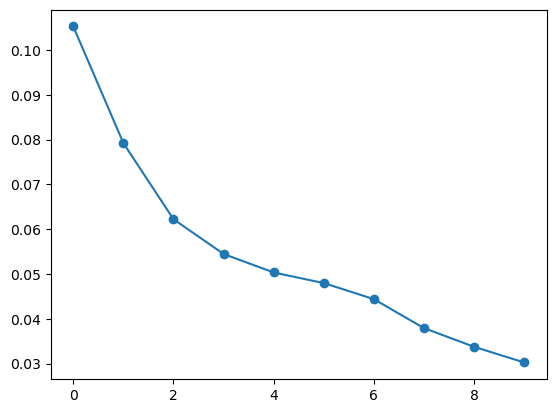

In [543]:
plt.figure()
plt.plot(explain,'-o')

In [535]:
explain[0]

0.10523382361156705

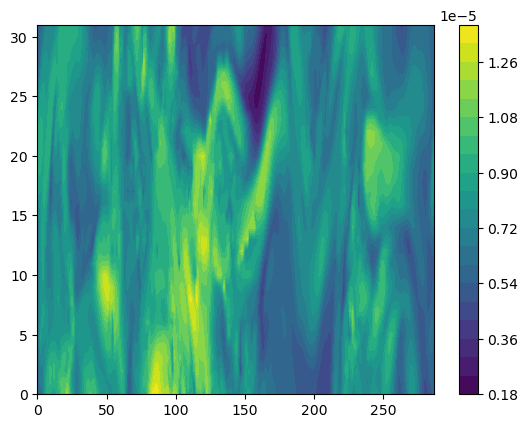

In [460]:
plt.figure()
plt.contourf(Q[0,10], levels=21)
plt.colorbar()

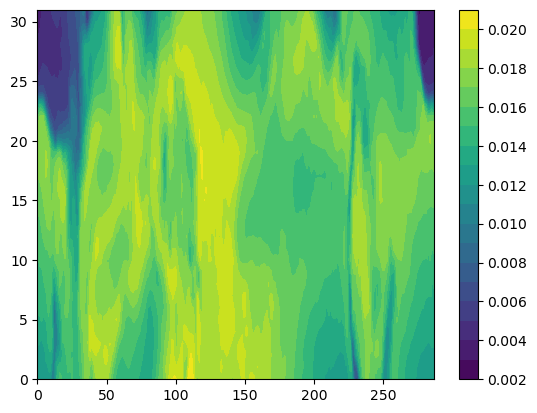

In [454]:
plt.figure()
plt.contourf(Q[0,-1], levels=21)
plt.colorbar()